In [3]:
##############################################################################################################
##############################################################################################################
######## R parallelization: k-means example on bivariate randomly generated data #############################
##############################################################################################################
##############################################################################################################


# This tutorial is about R parallelization and has been inspired from http://glennklockwood.com/di/R-para.php 


rm(list=ls()) #clear workspace
#setwd("~/Desktop/Lezione_22 Settembre_Modena")
source("genData.R") #loading the data generation function

install.packages("e1071", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
install.packages("doMC", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
install.packages("snow", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
install.packages("foreach", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")
library(e1071)
library(parallel)
library(foreach)
library(doMC)
library(snow)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


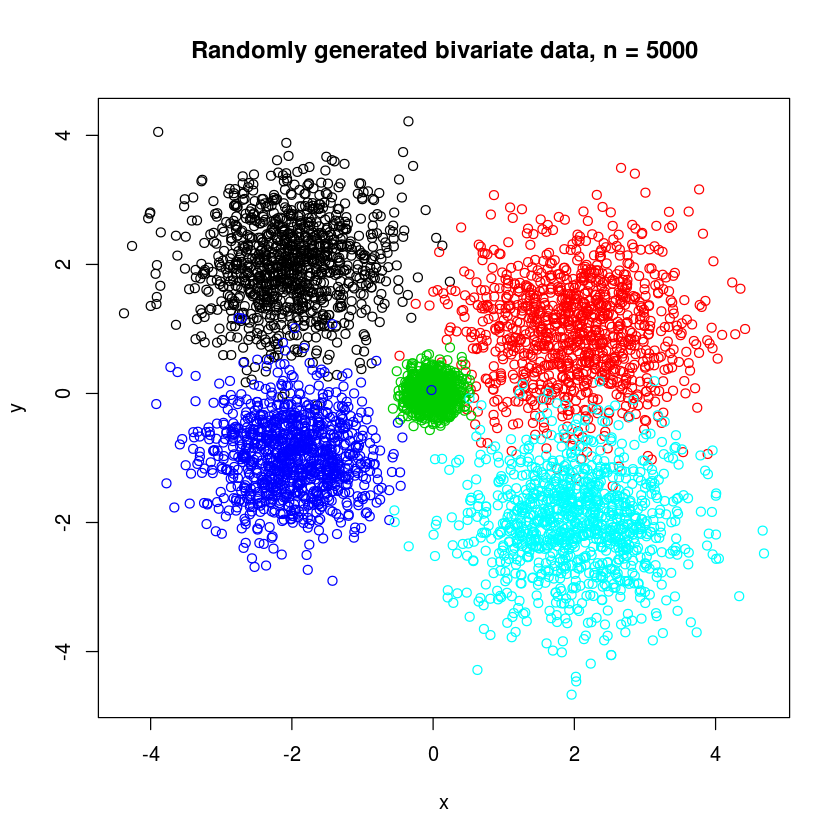

In [4]:
##############################################################################
######## data generation and data writing ####################################
##############################################################################

nrow <- 1000 # number of obs of each cluster
sd <- c(0.7,0.8,0.2,0.6,0.8) # standard deviation of each cluster
real.centers <- list( x=c(-2, 2, 0.0, -2, +2), y=c(2, 1, 0, -1, -2) ) # the real centers of the clusters
seed=1234 # set seed: in this way the generated data will be replicable

# data generation
data=genData(nrow,sd,real.centers,seed) # total: 5000 bivariate obs (1000 obs for each group)
labels=data$labels
data=data$data
plot(x=data[,1],y=data[,2],col=labels,main=paste("Randomly generated bivariate data, n =",nrow(data) ),xlab="x",ylab="y")
# elapsed time matrix
elapsed_time=data.frame()
elapsed_time[1:5,1]=c("serial","lapply","mclapply","foreach_noPar","foreach")
elapsed_time[1:5,2]=NA
colnames(elapsed_time)=c("type","time")

In [5]:
head(data)

x,y
-2.844946,1.1562666
-1.805800,2.2110267
-1.240891,0.9225983
-3.641988,2.4447595
-1.699613,2.4920662
-1.645761,0.6658820


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10


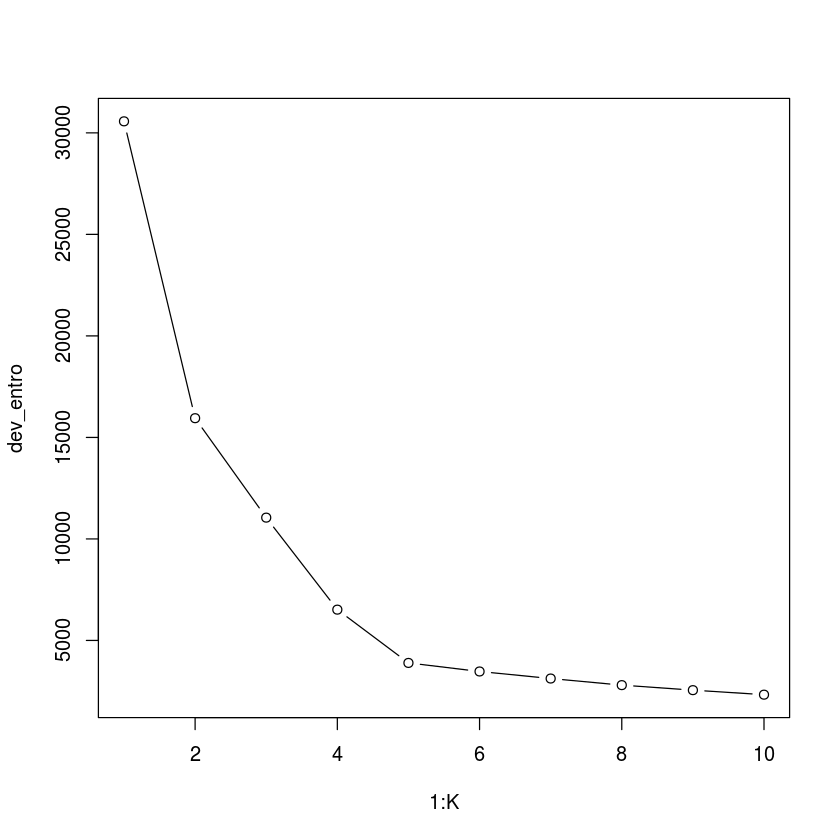

In [6]:
##############################################################################
######## definition of the parallelization function ##########################
##############################################################################

# how many cores do we want to exploit during the parallelization?
ncores=5


parallel.function <- function(i) { kmeans( x=data, centers=5, nstart=i ) }
# NB: the parallelization will not be about splitting the data, but about splitting the multiple starts
# the data are hard-coded in the function, the only variable here is the number of multiple starts

##### How many groups? #####

K=10
dev_entro=c()
for(i in 1:K )
{
  print(i)
  k_means=kmeans( data,  centers=i, nstart=50 )
  dev_entro=c(dev_entro,k_means$tot.withinss)
}

plot(1:K, dev_entro, type="b")
## warnings()

In [7]:
##############################################################################
######## EXAMPLE 1: standard SERIAL COMPUTING (no parallelization) ###########
##############################################################################

# A single call of kmeans() is now performed, with 300 different starting points

begin=Sys.time()
serial_result <- kmeans( data,  centers=5, nstart=300 ) #no need to use the parallelized function
end=Sys.time()
serial_time=end-begin
elapsed_time[1,2]=end-begin
print(serial_time)
rm(end,begin)
ls(serial_result)

Time difference of 1.198559 secs


[1] "betweenss"    "centers"      "cluster"      "ifault"       "iter"        
[6] "size"         "tot.withinss" "totss"        "withinss"

In [8]:
##############################################################################
################## EXAMPLE 2: lapply (no parallelization) ####################
##############################################################################

# A single call of kmeans() function is now split into a series of calls of kmeans!
# Each call tries a fraction of the original 100 starting points
# The elapsed run time won't be reduced, but potentially such calls can be run concurrently (see example 3)!


begin=Sys.time()
results_list <- lapply( rep(ceiling(300/ncores),times=ncores), FUN=parallel.function )
tot.withinss <- sapply( results_list, function(results_list) { results_list$tot.withinss } )
lapply_result <- results_list[[which.min(tot.withinss)]]
end=Sys.time()
lapply_time=end-begin
elapsed_time[2,2]=end-begin
print(lapply_time)
rm(end,begin,results_list,tot.withinss)
ls(lapply_result)


Time difference of 1.571322 secs


[1] "betweenss"    "centers"      "cluster"      "ifault"       "iter"        
[6] "size"         "tot.withinss" "totss"        "withinss"

In [9]:
##############################################################################
################## EXAMPLE 3: mclapply (shared-memory parallelism) ###########
##############################################################################


# The "parallel" library provides the mclapply() function which is a parallelized replacement for lapply
# This function distributes the lapply tasks across multiple CPU cores to be executed in parallel
# All of the hard work is in restructuring your problem to use lapply when, serially, it wouldn't necessarily make sense.
# WARNING: it does not work on Windows systems!!!

begin=Sys.time()
results_list <- mclapply( rep(ceiling(300/ncores),times=ncores), FUN=parallel.function , mc.cores=ncores )
tot.withinss <- sapply( results_list, function(results_list) { results_list$tot.withinss } )
mclapply_result <- results_list[[which.min(tot.withinss)]]
end=Sys.time()
mclapply_time=end-begin
elapsed_time[3,2]=end-begin
print(mclapply_time)
rm(end,begin,results_list,tot.withinss)
ls(mclapply_result)

Time difference of 0.3803005 secs


[1] "betweenss"    "centers"      "cluster"      "ifault"       "iter"        
[6] "size"         "tot.withinss" "totss"        "withinss"

In [10]:
##############################################################################
################## EXAMPLE 4: foreach (no parallelization) ###################
##############################################################################


# The "foreach" package must be used in conjunction with a package such as doParallel in order to execute code in parallel. 
# The user must register a parallel backend to use, otherwise foreach will execute tasks sequentially, 
# even when the %dopar% operator is used!!!


# no parallelization is achieved now
begin=Sys.time()
results_list <- foreach( i = rep(ceiling(300/ncores),times=ncores) ) %do% parallel.function(i)
tot.withinss <- sapply( results_list, function(results_list) { results_list$tot.withinss } )
foreach_result <- results_list[[which.min(tot.withinss)]]
end=Sys.time()
elapsed_time[4,2]=end-begin
foreach_time=end-begin
print(foreach_time)
rm(end,begin,results_list,tot.withinss,i)
ls(foreach_result)

Time difference of 1.617266 secs


[1] "betweenss"    "centers"      "cluster"      "ifault"       "iter"        
[6] "size"         "tot.withinss" "totss"        "withinss"

In [11]:
##############################################################################
######## EXAMPLE 5: foreach (shared-memory parallelism) ######################
##############################################################################

begin=Sys.time()
registerDoMC(ncores) #it is a necessary step in order to make foreach work in parallel
results_list <- foreach( i = rep(ceiling(300/ncores),times=ncores) ) %dopar% parallel.function(i)
tot.withinss <- sapply( results_list, function(results_list) { results_list$tot.withinss } )
doMC_result <- results_list[[which.min(tot.withinss)]]
end=Sys.time()
elapsed_time[5,2]=end-begin
doMC_time=end-begin
print(doMC_time)
rm(end,begin,results_list,tot.withinss)

ls(doMC_result)

Time difference of 0.4110453 secs


[1] "betweenss"    "centers"      "cluster"      "ifault"       "iter"        
[6] "size"         "tot.withinss" "totss"        "withinss"